In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization

In [2]:
import os
import skimage.io
import skimage.transform
from tqdm import tqdm
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def define_discriminator(in_shape=(224,224,3), n_classes=6):

    in_label = Input(shape=(1,))

    li = Embedding(n_classes, 50)(in_label)

    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    in_image = Input(shape=in_shape)

    merge = Concatenate()([in_image, li])

    fe = Conv2D(64, (5,5), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU()(fe)
    fe = Dropout(0.3)(fe)
    
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU()(fe)
    fe = Dropout(0.3)(fe)
    
    fe = Flatten()(fe)

    out_layer = Dense(1, activation='sigmoid')(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [4]:
def define_generator(latent_dim, n_classes=6):

    in_label = Input(shape=(1,))

    li = Embedding(n_classes, 50)(in_label)

    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)

    li = Reshape((7, 7, 1))(li)

    in_lat = Input(shape=(latent_dim,))
    
    gen = Dense(7*7*256)(in_lat)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    gen = Reshape((7,7,256))(gen)
    
    merge = Concatenate()([gen,li])
    
    gen = Conv2DTranspose(128, (5,5), strides = (1,1), padding='same', use_bias=False)(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(32, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(16, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(8, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    
    out_layer = Conv2DTranspose(3, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh')(gen)
   
    model = Model([in_lat, in_label], out_layer)
    return model

In [5]:
def define_gan(g_model, d_model):

    d_model.trainable = False

    gen_noise, gen_label = g_model.input

    gen_output = g_model.output

    gan_output = d_model([gen_output, gen_label])

    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
def load_real_samples():
    
    data_dirs = [d for d in os.listdir('dreamhouse_data/')]
    
    trainX = []
    costs = []
    
    print('loading training data')
    for dd in tqdm(data_dirs):
        houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
        with open('dreamhouse_data/{}/metadata.json'.format(dd)) as test_md:
            md = json.load(test_md)
        for house in houses_found:
            house_content = os.listdir('dreamhouse_data/{}/{}'.format(dd,house))
            if 'gsv_0.jpg' in house_content:
                try:
                    costs.append(md[house]['PRICE'])
                    path = 'dreamhouse_data/{}/{}/gsv_0.jpg'.format(dd,house)
                    x = skimage.io.imread(path)
                    x = skimage.transform.resize(x, (224,224))
                    trainX.append(x)
                except KeyError:
                    pass
    X = expand_dims(trainX,axis=-1)
    X = X.astype('float32')
    X = (X-127.5)/127.5
    
    price_df = pd.DataFrame({'costs':costs})
    bins = np.array([0,600000,1000000,1400000,1800000,2200000,float(np.Inf)])
    price_df['bin'] = pd.cut(price_df.costs,bins)
    cuts = list(set(price_df['bin'].to_list()))
    cuts = sorted(cuts)
    bin_ids = {cuts[i]:i for i in range(len(cuts))}
    price_df['cat'] = price_df['bin'].map(bin_ids)
    trainy = np.array(price_df['cat'].to_list())
    
    
    return [X, trainy]

In [7]:
def generate_real_samples(dataset, n_samples):

    images, labels = dataset

    ix = randint(0, images.shape[0], n_samples)
    
    X, labels = images[ix], labels[ix]

    y = ones((n_samples, 1))
    return [X, labels], y

In [8]:
def generate_latent_points(latent_dim, n_samples, n_classes=6):

    x_input = randn(latent_dim * n_samples)

    z_input = x_input.reshape(n_samples, latent_dim)

    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [9]:
def generate_fake_samples(generator, latent_dim, n_samples):

    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    images = generator.predict([z_input, labels_input])

    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [10]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        pbar = tqdm(range(bat_per_epo))

        for j in pbar:

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            pbar.set_postfix({'epoch':i,'g_loss':g_loss})
            
        generate_and_save_image(g_model,i)

    g_model.save(f'cgan_generator_{n_epochs}.h5')

In [14]:
!mkdir cgan_frames_300

In [18]:
def generate_and_save_image(model,epoch):
    test_pts, labs = generate_latent_points(100,6)
    labs = np.asarray(range(6))
    X = model.predict([test_pts,labs])
    X = (X+1)/2.
    
    fig  = plt.figure()
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.imshow(X[i,:,:,:])
        plt.axis('off')
        
    plt.savefig('cgan_frames_300/im_at_epoch{:04d}.png'.format(epoch))
    plt.show()

In [12]:
dataset = load_real_samples()

  0%|          | 0/203 [00:00<?, ?it/s]

loading training data


100%|██████████| 203/203 [01:04<00:00,  3.14it/s]


100%|██████████| 15/15 [01:29<00:00,  5.96s/it, epoch=0, g_loss=3.48]


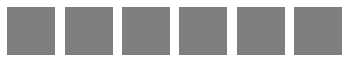

  7%|▋         | 1/15 [00:05<01:21,  5.79s/it, epoch=1, g_loss=3.27]

In [ ]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=100)